In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Install required packages
!pip install pytorch_lightning wandb torch torchvision pandas numpy matplotlib seaborn scikit-learn mlflow wand dagshub

# Set up Kaggle API
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 5.6 MB/s eta 0:00:00


In [3]:
# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip -q walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 706MB/s]


In [5]:
!unzip -q train.csv.zip
!unzip -q stores.csv.zip
!unzip -q test.csv.zip
!unzip -q features.csv.zip

unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import MLFlowLogger

# MLflow for experiment tracking
import mlflow
import mlflow.pytorch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [9]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [10]:
# MLflow Setup
mlflow.set_tracking_uri("./mlruns")
experiment_name = "NBEATS_Training"
mlflow.set_experiment(experiment_name)

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {experiment_name}")

2025/07/06 14:54:29 INFO mlflow.tracking.fluent: Experiment with name 'NBEATS_Training' does not exist. Creating a new experiment.


MLflow tracking URI: ./mlruns
Experiment: NBEATS_Training


# Load Walmart data

In [12]:
def load_walmart_data():
    """Load Walmart sales data"""
    try:
        # Try to load from different possible locations
        for path in ['../data/train.csv', './train.csv', '/content/train.csv']:
            if os.path.exists(path):
                return pd.read_csv(path)

        # If no data found, create dummy data for testing
        print("No data file found. Creating dummy data for testing...")
        return create_dummy_data()
    except Exception as e:
        print(f"Error loading data: {e}")
        return create_dummy_data()

In [13]:
# Load data
df = load_walmart_data()
print(f"Data shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Unique stores: {df['Store'].nunique()}")
print(f"Unique departments: {df['Dept'].nunique()}")

Data shape: (421570, 5)
Date range: 2010-02-05 to 2012-10-26
Unique stores: 45
Unique departments: 81


# Preprocess data


In [16]:
import pandas as pd
import numpy as np

def preprocess_data(df):
    """Comprehensive data preprocessing"""
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    # Sort by Store, Dept, Date
    df = df.sort_values(['Store', 'Dept', 'Date'])

    # Create time-based features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Quarter'] = df['Date'].dt.quarter
    df['DayOfYear'] = df['Date'].dt.dayofyear

    # Cyclical encoding for better pattern recognition
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
    df['Week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)

    # Create lag features
    for lag in [1, 2, 4, 8, 12, 52]:
        df[f'Sales_lag_{lag}'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)

    # Create rolling statistics — FIXED with transform so index aligns!
    for window in [4, 8, 12, 26]:
        df[f'Sales_rolling_mean_{window}'] = (
            df.groupby(['Store', 'Dept'])['Weekly_Sales']
            .transform(lambda x: x.rolling(window, min_periods=1).mean())
        )
        df[f'Sales_rolling_std_{window}'] = (
            df.groupby(['Store', 'Dept'])['Weekly_Sales']
            .transform(lambda x: x.rolling(window, min_periods=1).std())
        )

    # Fill missing values
    df = df.fillna(method='ffill').fillna(method='bfill')

    return df


In [17]:
df_processed = preprocess_data(df)
print(f"Processed data shape: {df_processed.shape}")
print(f"Missing values: {df_processed.isnull().sum().sum()}")

Processed data shape: (421570, 28)
Missing values: 0


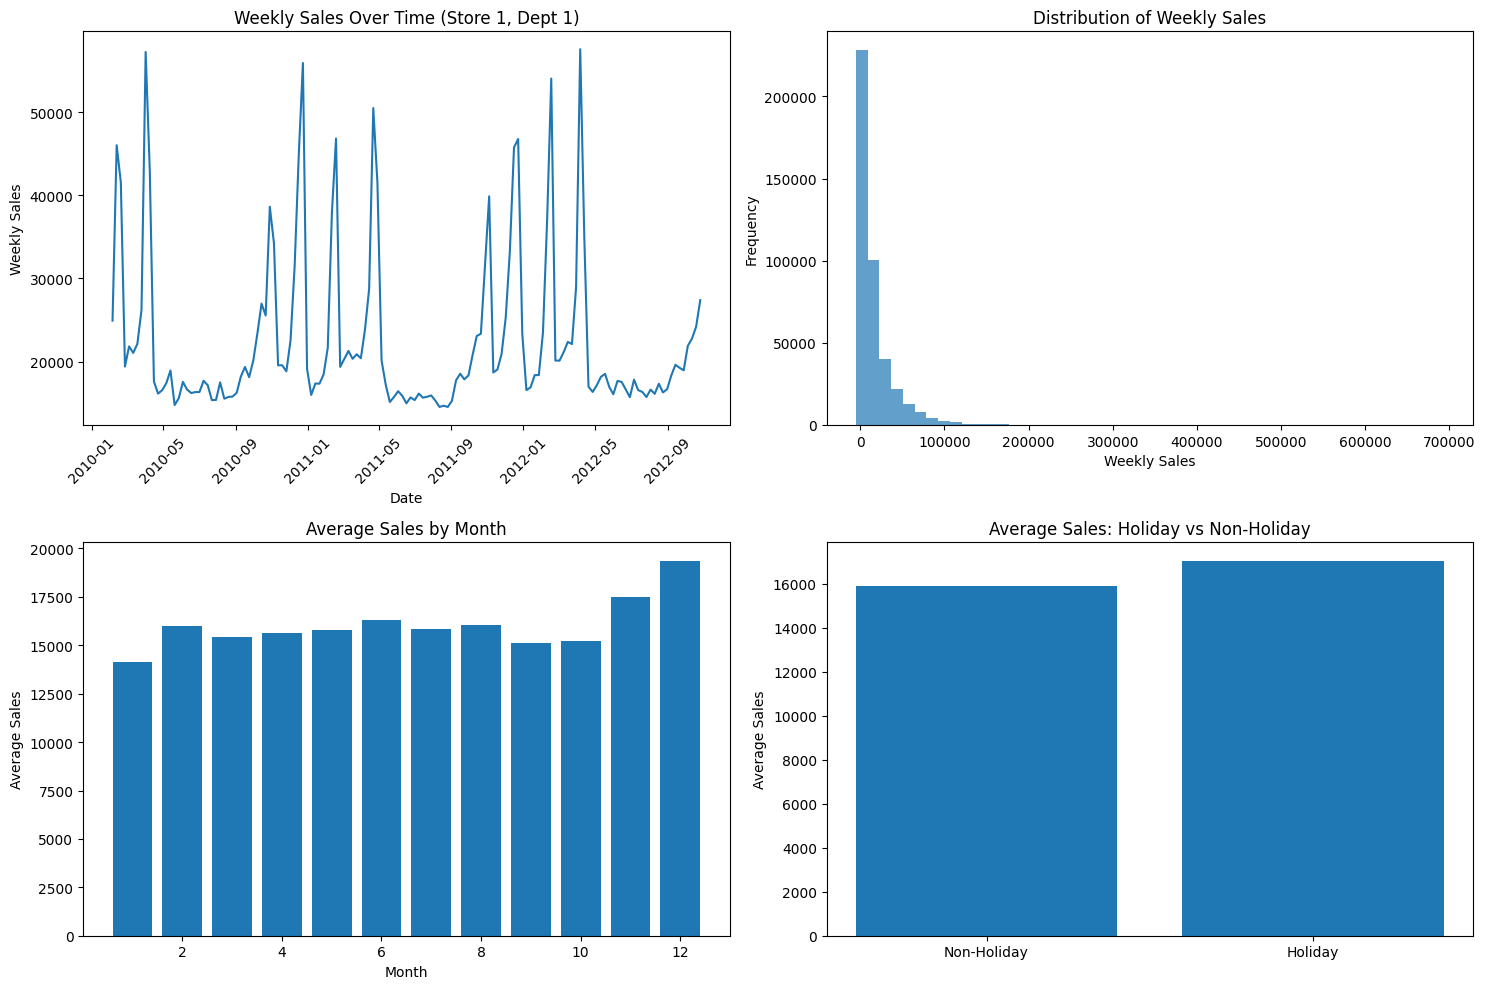

In [18]:
# %% [markdown]
# ## Exploratory Data Analysis

# %%
# EDA for N-BEATS model understanding
plt.figure(figsize=(15, 10))

# Plot 1: Sales over time for a sample store-dept combination
plt.subplot(2, 2, 1)
sample_data = df_processed[(df_processed['Store'] == 1) & (df_processed['Dept'] == 1)]
plt.plot(sample_data['Date'], sample_data['Weekly_Sales'])
plt.title('Weekly Sales Over Time (Store 1, Dept 1)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)

# Plot 2: Sales distribution
plt.subplot(2, 2, 2)
plt.hist(df_processed['Weekly_Sales'], bins=50, alpha=0.7)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')

# Plot 3: Seasonal patterns
plt.subplot(2, 2, 3)
monthly_sales = df_processed.groupby('Month')['Weekly_Sales'].mean()
plt.bar(monthly_sales.index, monthly_sales.values)
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')

# Plot 4: Holiday effect
plt.subplot(2, 2, 4)
holiday_sales = df_processed.groupby('IsHoliday')['Weekly_Sales'].mean()
plt.bar(['Non-Holiday', 'Holiday'], holiday_sales.values)
plt.title('Average Sales: Holiday vs Non-Holiday')
plt.ylabel('Average Sales')

plt.tight_layout()
plt.show()

In [19]:
# ## N-BEATS Model Implementation

# %%
class NBeatsBlock(nn.Module):
    """Individual N-BEATS block with interpretable basis functions"""

    def __init__(self, input_size, theta_size, basis_function, layers, layer_size):
        super().__init__()
        self.input_size = input_size
        self.theta_size = theta_size
        self.basis_function = basis_function

        # Fully connected layers
        self.fc_layers = nn.ModuleList([nn.Linear(input_size if i == 0 else layer_size, layer_size)
                                       for i in range(layers)])

        # Theta layers for backcast and forecast
        self.theta_b = nn.Linear(layer_size, theta_size)
        self.theta_f = nn.Linear(layer_size, theta_size)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass through FC layers
        for layer in self.fc_layers:
            x = self.relu(layer(x))

        # Generate theta parameters
        theta_b = self.theta_b(x)
        theta_f = self.theta_f(x)

        # Apply basis functions
        backcast = self.basis_function(theta_b, self.input_size, backcast=True)
        forecast = self.basis_function(theta_f, self.input_size, backcast=False)

        return backcast, forecast

class GenericBasisFunction(nn.Module):
    """Generic basis function for N-BEATS"""

    def __init__(self, forecast_length):
        super().__init__()
        self.forecast_length = forecast_length

    def forward(self, theta, input_size, backcast=True):
        if backcast:
            return theta[:, :input_size]
        else:
            return theta[:, :self.forecast_length]

class TrendBasisFunction(nn.Module):
    """Trend basis function for interpretable N-BEATS"""

    def __init__(self, forecast_length, degree=3):
        super().__init__()
        self.forecast_length = forecast_length
        self.degree = degree

    def forward(self, theta, input_size, backcast=True):
        batch_size = theta.size(0)

        if backcast:
            T = torch.arange(input_size, dtype=torch.float32, device=theta.device)
        else:
            T = torch.arange(self.forecast_length, dtype=torch.float32, device=theta.device)

        # Create polynomial basis
        basis = torch.stack([T**i for i in range(self.degree + 1)], dim=1)
        basis = basis.unsqueeze(0).repeat(batch_size, 1, 1)

        # Apply theta parameters
        theta_expanded = theta[:, :self.degree + 1].unsqueeze(1)
        result = torch.bmm(theta_expanded, basis.transpose(1, 2)).squeeze(1)

        return result

class SeasonalBasisFunction(nn.Module):
    """Seasonal basis function for interpretable N-BEATS"""

    def __init__(self, forecast_length, harmonics=10):
        super().__init__()
        self.forecast_length = forecast_length
        self.harmonics = harmonics

    def forward(self, theta, input_size, backcast=True):
        batch_size = theta.size(0)

        if backcast:
            T = torch.arange(input_size, dtype=torch.float32, device=theta.device)
        else:
            T = torch.arange(self.forecast_length, dtype=torch.float32, device=theta.device)

        # Create harmonic basis
        basis = []
        for i in range(1, self.harmonics + 1):
            basis.append(torch.sin(2 * np.pi * i * T / 52))  # Weekly seasonality
            basis.append(torch.cos(2 * np.pi * i * T / 52))

        basis = torch.stack(basis, dim=1)
        basis = basis.unsqueeze(0).repeat(batch_size, 1, 1)

        # Apply theta parameters
        theta_expanded = theta[:, :2 * self.harmonics].unsqueeze(1)
        result = torch.bmm(theta_expanded, basis.transpose(1, 2)).squeeze(1)

        return result

class NBeatsModel(pl.LightningModule):
    """N-BEATS model with both generic and interpretable stacks"""

    def __init__(self, input_size=52, forecast_length=39,
                 generic_stacks=2, interpretable_stacks=2,
                 blocks_per_stack=3, layer_size=512, layers=4,
                 theta_size=None, learning_rate=1e-3, weight_decay=1e-8):
        super().__init__()
        self.save_hyperparameters()

        self.input_size = input_size
        self.forecast_length = forecast_length
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        # Calculate theta size if not provided
        if theta_size is None:
            theta_size = max(input_size, forecast_length)

        # Generic stacks
        self.generic_stacks = nn.ModuleList()
        for _ in range(generic_stacks):
            stack = nn.ModuleList()
            for _ in range(blocks_per_stack):
                basis_function = GenericBasisFunction(forecast_length)
                block = NBeatsBlock(input_size, theta_size, basis_function, layers, layer_size)
                stack.append(block)
            self.generic_stacks.append(stack)

        # Interpretable stacks
        self.interpretable_stacks = nn.ModuleList()
        basis_functions = [
            TrendBasisFunction(forecast_length, degree=3),
            SeasonalBasisFunction(forecast_length, harmonics=10)
        ]

        for i in range(interpretable_stacks):
            stack = nn.ModuleList()
            basis_function = basis_functions[i % len(basis_functions)]
            for _ in range(blocks_per_stack):
                block = NBeatsBlock(input_size, theta_size, basis_function, layers, layer_size)
                stack.append(block)
            self.interpretable_stacks.append(stack)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, features)
        # For N-BEATS, we primarily use the target variable
        if x.dim() == 3:
            x = x[:, :, 0]  # Use only Weekly_Sales

        batch_size = x.size(0)
        forecast = torch.zeros(batch_size, self.forecast_length, device=x.device)
        residual = x

        # Process generic stacks
        for stack in self.generic_stacks:
            stack_forecast = torch.zeros(batch_size, self.forecast_length, device=x.device)

            for block in stack:
                backcast, block_forecast = block(residual)
                residual = residual - backcast
                stack_forecast = stack_forecast + block_forecast

            forecast = forecast + stack_forecast

        # Process interpretable stacks
        for stack in self.interpretable_stacks:
            stack_forecast = torch.zeros(batch_size, self.forecast_length, device=x.device)

            for block in stack:
                backcast, block_forecast = block(residual)
                residual = residual - backcast
                stack_forecast = stack_forecast + block_forecast

            forecast = forecast + stack_forecast

        return forecast

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.MSELoss()(y_pred, y)

        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)

        # Calculate losses
        mse_loss = nn.MSELoss()(y_pred, y)
        mae_loss = nn.L1Loss()(y_pred, y)

        # Log metrics
        self.log('val_loss', mse_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_mae', mae_loss, on_step=False, on_epoch=True, prog_bar=True)

        return mse_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }

In [20]:
# ## Dataset Preparation

# %%
class WalmartTimeSeriesDataset(Dataset):
    """Custom dataset for Walmart time series data"""

    def __init__(self, data, sequence_length=52, forecast_length=39,
                 target_col='Weekly_Sales', feature_cols=None, scaler=None):
        self.data = data.copy()
        self.sequence_length = sequence_length
        self.forecast_length = forecast_length
        self.target_col = target_col

        # Default feature columns
        if feature_cols is None:
            self.feature_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI',
                               'Unemployment', 'IsHoliday', 'Month_sin', 'Month_cos',
                               'Week_sin', 'Week_cos']
        else:
            self.feature_cols = feature_cols

        # Prepare data by store-department combinations
        self.sequences = []
        self.targets = []

        # Group by store and department
        for (store, dept), group in self.data.groupby(['Store', 'Dept']):
            group = group.sort_values('Date')

            # Skip if not enough data
            if len(group) < sequence_length + forecast_length:
                continue

            # Create sequences
            for i in range(len(group) - sequence_length - forecast_length + 1):
                # Input sequence
                seq_data = group.iloc[i:i + sequence_length]

                # Target sequence
                target_data = group.iloc[i + sequence_length:i + sequence_length + forecast_length]

                # Store sequence and target
                self.sequences.append(seq_data[self.feature_cols].values)
                self.targets.append(target_data[self.target_col].values)

        # Convert to numpy arrays
        self.sequences = np.array(self.sequences, dtype=np.float32)
        self.targets = np.array(self.targets, dtype=np.float32)

        # Normalize data
        if scaler is None:
            self.scaler = StandardScaler()
            # Fit on sequences (reshape to 2D)
            sequences_2d = self.sequences.reshape(-1, self.sequences.shape[-1])
            self.scaler.fit(sequences_2d)
        else:
            self.scaler = scaler

        # Apply normalization
        for i in range(len(self.sequences)):
            self.sequences[i] = self.scaler.transform(self.sequences[i])

        # Normalize targets separately
        self.target_scaler = StandardScaler()
        targets_2d = self.targets.reshape(-1, 1)
        self.target_scaler.fit(targets_2d)

        for i in range(len(self.targets)):
            self.targets[i] = self.target_scaler.transform(self.targets[i].reshape(-1, 1)).flatten()

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.FloatTensor(self.targets[idx])

# Create datasets
print("Creating datasets...")

# Use data until 2012-01-01 for training, rest for validation
train_end_date = pd.to_datetime('2012-01-01')
train_data = df_processed[df_processed['Date'] < train_end_date]
val_data = df_processed[df_processed['Date'] >= train_end_date]

print(f"Training data: {len(train_data)} samples")
print(f"Validation data: {len(val_data)} samples")

# Create datasets
train_dataset = WalmartTimeSeriesDataset(train_data, sequence_length=52, forecast_length=39)
val_dataset = WalmartTimeSeriesDataset(val_data, sequence_length=52, forecast_length=39,
                                      scaler=train_dataset.scaler)

print(f"Training sequences: {len(train_dataset)}")
print(f"Validation sequences: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# %% [markdown]
# ## Model Training

# %%
def train_nbeats_model(hyperparams, run_name):
    """Train N-BEATS model with given hyperparameters"""

    with mlflow.start_run(run_name=run_name):
        # Log hyperparameters
        mlflow.log_params(hyperparams)

        # Create model
        model = NBeatsModel(**hyperparams)

        # MLflow logger
        mlflow_logger = MLFlowLogger(
            experiment_name=experiment_name,
            run_id=mlflow.active_run().info.run_id
        )

        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=15,
            verbose=True,
            mode='min',
            min_delta=0.001
        )

        checkpoint = ModelCheckpoint(
            monitor='val_loss',
            mode='min',
            save_top_k=1,
            verbose=True,
            dirpath=f'./checkpoints/{run_name}',
            filename='best-model'
        )

        # Trainer
        trainer = pl.Trainer(
            max_epochs=hyperparams.get('max_epochs', 100),
            callbacks=[early_stopping, checkpoint],
            logger=mlflow_logger,
            log_every_n_steps=10,
            accelerator='auto',
            devices='auto',
            deterministic=True
        )

        # Train model
        trainer.fit(model, train_loader, val_loader)

        # Load best model
        best_model = NBeatsModel.load_from_checkpoint(checkpoint.best_model_path)

        # Evaluate on validation set
        trainer.validate(best_model, val_loader)

        # Log final metrics
        if trainer.logged_metrics:
            for key, value in trainer.logged_metrics.items():
                mlflow.log_metric(key, float(value))

        # Log model
        mlflow.pytorch.log_model(best_model, "model")

        # Save model to registry if it's the best so far
        model_version = mlflow.register_model(
            f"runs:/{mlflow.active_run().info.run_id}/model",
            "nbeats_walmart_forecasting"
        )

        return trainer, best_model, trainer.logged_metrics

# %% [markdown]
# ## Hyperparameter Experiments

# %%
# MLflow experiment: Data preprocessing
with mlflow.start_run(run_name="NBEATS_Data_Preprocessing"):
    # Log data preprocessing parameters
    mlflow.log_params({
        'sequence_length': 52,
        'forecast_length': 39,
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'normalization': 'StandardScaler',
        'feature_engineering': 'lag_features_rolling_stats_cyclical_encoding'
    })

    # Log data statistics
    mlflow.log_metrics({
        'train_mean_sales': float(train_data['Weekly_Sales'].mean()),
        'train_std_sales': float(train_data['Weekly_Sales'].std()),
        'val_mean_sales': float(val_data['Weekly_Sales'].mean()),
        'val_std_sales': float(val_data['Weekly_Sales'].std())
    })


Creating datasets...
Training data: 294132 samples
Validation data: 127438 samples


KeyError: "['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'] not in index"